## Trial of as many Time Series Analysis as possible for solar resource from SAM (System Advisor Model)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from agrivoltaics_supply_side_management.solar_irradiation.clearsky import get_clearsky

In [4]:
vancouver_data = pd.read_csv("../../data/weather_data/vancouver_bc_canada_49.263566_-123.138572_psm3_60_tmy.csv",
                             header=[2])

In [5]:
vancouver_data

,Year,Month,Day,Hour,Minute,DNI,DHI,GHI,Dew Point,Temperature,Pressure,Wind Direction,Wind Speed
0,2011,1,1,0,30,0,0,0,-8,-2,1020,75,2.1
1,2011,1,1,1,30,0,0,0,-8,-3,1020,74,2.1
2,2011,1,1,2,30,0,0,0,-8,-3,1020,74,2.0
3,2011,1,1,3,30,0,0,0,-8,-3,1020,70,1.9
4,2011,1,1,4,30,0,0,0,-9,-3,1020,64,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2011,12,31,19,30,0,0,0,-8,-2,1020,66,2.2
8756,2011,12,31,20,30,0,0,0,-8,-2,1020,69,2.2
8757,2011,12,31,21,30,0,0,0,-8,-2,1020,72,2.2
8758,2011,12,31,22,30,0,0,0,-8,-2,1020,76,2.2


In [6]:
vancouver_meta_data = pd.read_csv("../../data/weather_data/vancouver_bc_canada_49.263566_-123.138572_psm3_60_tmy.csv",
                                  header=[0], skiprows=lambda x: x not in [0, 1])

In [7]:
vancouver_meta_data

,Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,Local Time Zone,Dew Point Units,DHI Units,DNI Units,GHI Units,Temperature Units,Pressure Units,Wind Direction Units,Wind Speed,Surface Albedo Units,Version
0,NSRDB,262015,-,-,-,49.25,-123.14,-8,39,-8,c,w/m2,w/m2,w/m2,c,mbar,Degrees,m/s,NaN,3.1.1


In [8]:
vancouver_data['Datetime'] = pd.to_datetime(vancouver_data[['Year', 'Month', 'Day', 'Hour', 'Minute']])

In [9]:
vancouver_data

,Year,Month,Day,Hour,Minute,DNI,DHI,GHI,Dew Point,Temperature,Pressure,Wind Direction,Wind Speed,Datetime
0,2011,1,1,0,30,0,0,0,-8,-2,1020,75,2.1,2011-01-01 00:30:00
1,2011,1,1,1,30,0,0,0,-8,-3,1020,74,2.1,2011-01-01 01:30:00
2,2011,1,1,2,30,0,0,0,-8,-3,1020,74,2.0,2011-01-01 02:30:00
3,2011,1,1,3,30,0,0,0,-8,-3,1020,70,1.9,2011-01-01 03:30:00
4,2011,1,1,4,30,0,0,0,-9,-3,1020,64,1.8,2011-01-01 04:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2011,12,31,19,30,0,0,0,-8,-2,1020,66,2.2,2011-12-31 19:30:00
8756,2011,12,31,20,30,0,0,0,-8,-2,1020,69,2.2,2011-12-31 20:30:00
8757,2011,12,31,21,30,0,0,0,-8,-2,1020,72,2.2,2011-12-31 21:30:00
8758,2011,12,31,22,30,0,0,0,-8,-2,1020,76,2.2,2011-12-31 22:30:00


In [10]:
vancouver_data.set_index('Datetime', inplace=True)

In [11]:
vancouver_data

,Year,Month,Day,Hour,Minute,DNI,DHI,GHI,Dew Point,Temperature,Pressure,Wind Direction,Wind Speed
Datetime,,,,,,,,,,,,,
2011-01-01 00:30:00,2011,1,1,0,30,0,0,0,-8,-2,1020,75,2.1
2011-01-01 01:30:00,2011,1,1,1,30,0,0,0,-8,-3,1020,74,2.1
2011-01-01 02:30:00,2011,1,1,2,30,0,0,0,-8,-3,1020,74,2.0
2011-01-01 03:30:00,2011,1,1,3,30,0,0,0,-8,-3,1020,70,1.9
2011-01-01 04:30:00,2011,1,1,4,30,0,0,0,-9,-3,1020,64,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31 19:30:00,2011,12,31,19,30,0,0,0,-8,-2,1020,66,2.2
2011-12-31 20:30:00,2011,12,31,20,30,0,0,0,-8,-2,1020,69,2.2
2011-12-31 21:30:00,2011,12,31,21,30,0,0,0,-8,-2,1020,72,2.2


In [12]:
vancouver_data.index = vancouver_data.index.tz_localize('Canada/Pacific', 
                                                        ambiguous='NaT', nonexistent='shift_forward')

In [13]:
vancouver_data

,Year,Month,Day,Hour,Minute,DNI,DHI,GHI,Dew Point,Temperature,Pressure,Wind Direction,Wind Speed
Datetime,,,,,,,,,,,,,
2011-01-01 00:30:00-08:00,2011,1,1,0,30,0,0,0,-8,-2,1020,75,2.1
2011-01-01 01:30:00-08:00,2011,1,1,1,30,0,0,0,-8,-3,1020,74,2.1
2011-01-01 02:30:00-08:00,2011,1,1,2,30,0,0,0,-8,-3,1020,74,2.0
2011-01-01 03:30:00-08:00,2011,1,1,3,30,0,0,0,-8,-3,1020,70,1.9
2011-01-01 04:30:00-08:00,2011,1,1,4,30,0,0,0,-9,-3,1020,64,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31 19:30:00-08:00,2011,12,31,19,30,0,0,0,-8,-2,1020,66,2.2
2011-12-31 20:30:00-08:00,2011,12,31,20,30,0,0,0,-8,-2,1020,69,2.2
2011-12-31 21:30:00-08:00,2011,12,31,21,30,0,0,0,-8,-2,1020,72,2.2


In [14]:
vancouver_data.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)

In [15]:
vancouver_data

,DNI,DHI,GHI,Dew Point,Temperature,Pressure,Wind Direction,Wind Speed
Datetime,,,,,,,,
2011-01-01 00:30:00-08:00,0,0,0,-8,-2,1020,75,2.1
2011-01-01 01:30:00-08:00,0,0,0,-8,-3,1020,74,2.1
2011-01-01 02:30:00-08:00,0,0,0,-8,-3,1020,74,2.0
2011-01-01 03:30:00-08:00,0,0,0,-8,-3,1020,70,1.9
2011-01-01 04:30:00-08:00,0,0,0,-9,-3,1020,64,1.8
...,...,...,...,...,...,...,...,...
2011-12-31 19:30:00-08:00,0,0,0,-8,-2,1020,66,2.2
2011-12-31 20:30:00-08:00,0,0,0,-8,-2,1020,69,2.2
2011-12-31 21:30:00-08:00,0,0,0,-8,-2,1020,72,2.2


In [16]:
vancouver_data_ghi = vancouver_data.GHI

In [17]:
vancouver_data_ghi

Datetime
2011-01-01 00:30:00-08:00    0
2011-01-01 01:30:00-08:00    0
2011-01-01 02:30:00-08:00    0
2011-01-01 03:30:00-08:00    0
2011-01-01 04:30:00-08:00    0
                            ..
2011-12-31 19:30:00-08:00    0
2011-12-31 20:30:00-08:00    0
2011-12-31 21:30:00-08:00    0
2011-12-31 22:30:00-08:00    0
2011-12-31 23:30:00-08:00    0
Name: GHI, Length: 8760, dtype: int64

In [18]:
vancouver_data_ghi.shape

(8760,)

In [19]:
vancouver_data_ghi_0706 = vancouver_data_ghi[vancouver_data_ghi.index.strftime('%m-%d')=='07-06']

In [20]:
vancouver_data_ghi_0706

Datetime
2002-07-06 00:30:00-07:00      0
2002-07-06 01:30:00-07:00      0
2002-07-06 02:30:00-07:00      0
2002-07-06 03:30:00-07:00      0
2002-07-06 04:30:00-07:00     11
2002-07-06 05:30:00-07:00    102
2002-07-06 06:30:00-07:00    264
2002-07-06 07:30:00-07:00    446
2002-07-06 08:30:00-07:00    603
2002-07-06 09:30:00-07:00    739
2002-07-06 10:30:00-07:00    841
2002-07-06 11:30:00-07:00    901
2002-07-06 12:30:00-07:00    915
2002-07-06 13:30:00-07:00    878
2002-07-06 14:30:00-07:00    796
2002-07-06 15:30:00-07:00    677
2002-07-06 16:30:00-07:00    529
2002-07-06 17:30:00-07:00    365
2002-07-06 18:30:00-07:00    186
2002-07-06 19:30:00-07:00     43
2002-07-06 20:30:00-07:00      0
2002-07-06 21:30:00-07:00      0
2002-07-06 22:30:00-07:00      0
2002-07-06 23:30:00-07:00      0
Name: GHI, dtype: int64

<AxesSubplot:xlabel='Datetime'>

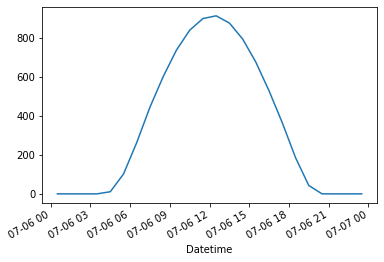

In [21]:
vancouver_data_ghi_0706.plot()

In [22]:
vancouver_data_ghi_0717 = vancouver_data_ghi[vancouver_data_ghi.index.strftime('%m-%d')=='07-17']

In [23]:
vancouver_data_ghi_0717

Datetime
2002-07-17 00:30:00-07:00      0
2002-07-17 01:30:00-07:00      0
2002-07-17 02:30:00-07:00      0
2002-07-17 03:30:00-07:00      0
2002-07-17 04:30:00-07:00      0
2002-07-17 05:30:00-07:00     16
2002-07-17 06:30:00-07:00      8
2002-07-17 07:30:00-07:00    165
2002-07-17 08:30:00-07:00    238
2002-07-17 09:30:00-07:00    172
2002-07-17 10:30:00-07:00    278
2002-07-17 11:30:00-07:00    382
2002-07-17 12:30:00-07:00    350
2002-07-17 13:30:00-07:00    316
2002-07-17 14:30:00-07:00    211
2002-07-17 15:30:00-07:00    286
2002-07-17 16:30:00-07:00    192
2002-07-17 17:30:00-07:00     96
2002-07-17 18:30:00-07:00     24
2002-07-17 19:30:00-07:00      5
2002-07-17 20:30:00-07:00      0
2002-07-17 21:30:00-07:00      0
2002-07-17 22:30:00-07:00      0
2002-07-17 23:30:00-07:00      0
Name: GHI, dtype: int64

<AxesSubplot:xlabel='Datetime'>

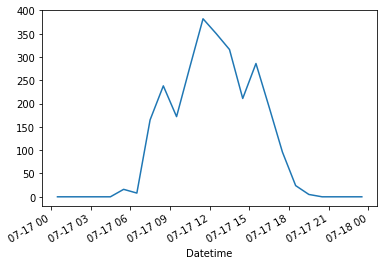

In [24]:
vancouver_data_ghi_0717.plot()

### Get clearsky data for the same day

In [25]:
vancouver_data_ghi_0717.index

DatetimeIndex(['2002-07-17 00:30:00-07:00', '2002-07-17 01:30:00-07:00',
               '2002-07-17 02:30:00-07:00', '2002-07-17 03:30:00-07:00',
               '2002-07-17 04:30:00-07:00', '2002-07-17 05:30:00-07:00',
               '2002-07-17 06:30:00-07:00', '2002-07-17 07:30:00-07:00',
               '2002-07-17 08:30:00-07:00', '2002-07-17 09:30:00-07:00',
               '2002-07-17 10:30:00-07:00', '2002-07-17 11:30:00-07:00',
               '2002-07-17 12:30:00-07:00', '2002-07-17 13:30:00-07:00',
               '2002-07-17 14:30:00-07:00', '2002-07-17 15:30:00-07:00',
               '2002-07-17 16:30:00-07:00', '2002-07-17 17:30:00-07:00',
               '2002-07-17 18:30:00-07:00', '2002-07-17 19:30:00-07:00',
               '2002-07-17 20:30:00-07:00', '2002-07-17 21:30:00-07:00',
               '2002-07-17 22:30:00-07:00', '2002-07-17 23:30:00-07:00'],
              dtype='datetime64[ns, Canada/Pacific]', name='Datetime', freq=None)

In [26]:
vancouver_clearsky_ghi_0717 = get_clearsky(49.263566, -123.138572, 
                                           'Canada/Pacific', vancouver_data_ghi_0717.index,
                                           location_name='Vancouver, BC, Canada')['ghi']

In [27]:
vancouver_clearsky_ghi_0717

Datetime
2002-07-17 00:30:00-07:00      0.000000
2002-07-17 01:30:00-07:00      0.000000
2002-07-17 02:30:00-07:00      0.000000
2002-07-17 03:30:00-07:00      0.000000
2002-07-17 04:30:00-07:00      0.000000
2002-07-17 05:30:00-07:00      0.049742
2002-07-17 06:30:00-07:00     68.561097
2002-07-17 07:30:00-07:00    222.671380
2002-07-17 08:30:00-07:00    391.407154
2002-07-17 09:30:00-07:00    550.889221
2002-07-17 10:30:00-07:00    686.901315
2002-07-17 11:30:00-07:00    788.912796
2002-07-17 12:30:00-07:00    849.411568
2002-07-17 13:30:00-07:00    864.027151
2002-07-17 14:30:00-07:00    831.702461
2002-07-17 15:30:00-07:00    754.742638
2002-07-17 16:30:00-07:00    638.714004
2002-07-17 17:30:00-07:00    492.259700
2002-07-17 18:30:00-07:00    327.127361
2002-07-17 19:30:00-07:00    159.822949
2002-07-17 20:30:00-07:00     25.086362
2002-07-17 21:30:00-07:00      0.000000
2002-07-17 22:30:00-07:00      0.000000
2002-07-17 23:30:00-07:00      0.000000
Name: ghi, dtype: float64

<AxesSubplot:xlabel='Datetime'>

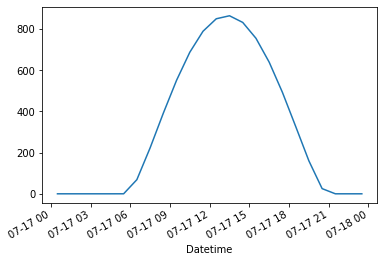

In [28]:
vancouver_clearsky_ghi_0717.plot()

<AxesSubplot:xlabel='Datetime'>

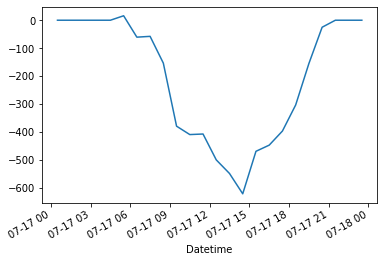

In [30]:
(vancouver_data_ghi_0717 - vancouver_clearsky_ghi_0717).plot()

In [31]:
vancouver_clearsky_ghi_0717.max()

864.0271509397637

In [32]:
vancouver_data_ghi_0717.max()

382

#### Change the clear sky data to the scale of cloudy sky data

In [35]:
vancouver_clearsky_ghi_scaled_0717 = vancouver_clearsky_ghi_0717 * (
    vancouver_data_ghi_0717.max() / vancouver_clearsky_ghi_0717.max())

<AxesSubplot:xlabel='Datetime'>

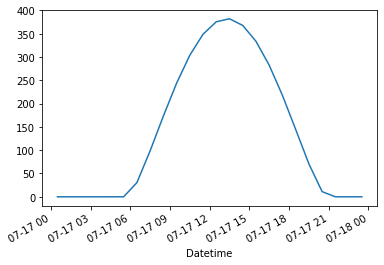

In [36]:
vancouver_clearsky_ghi_scaled_0717.plot()

In [38]:
vancouver_data_data_residual_0717 = vancouver_data_ghi_0717 - vancouver_clearsky_ghi_scaled_0717

<AxesSubplot:xlabel='Datetime'>

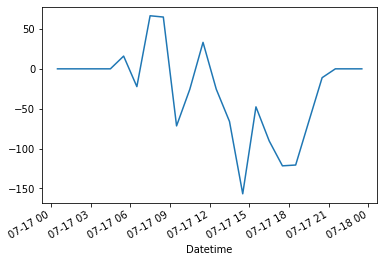

In [39]:
vancouver_data_data_residual_0717.plot()

### Try to apply Bayesian Time Series Analysis on this data, using PyMC3

In [1]:
import pymc3 as pm